#### Achtung: Dieses Notebook benötigt die _aktuellste_ next-Version von PyDelta

Installation mit

```bash
pip install -U https://github.com/fotis007/pydelta@next
```

In [1]:
%pylab inline
mpl.style.use('ggplot')
import delta
import pandas as pd
import random

Populating the interactive namespace from numpy and matplotlib


In [2]:
de = delta.Corpus('/home/tv/git/pydelta/corpus_DE')
de1000 = de.get_mfw_table(1000)
z = delta.registry.z_score(de1000)

Da wir die z-Scores bereits bestimmt haben, müssen wir nun nur noch 'den Rest' der Funktionen rechnen:

In [3]:
methods = {
    'cosine_delta' : delta.registry.delta('cosine'),
    'burrows_delta': delta.registry.delta('manhattan'),
    'eders_delta'  : delta.CompositeDeltaFunction('manhattan-eder_std', name='eders_delta', register=False),
    'euclidean'    : delta.PDistDeltaFunction('euclidean', register=False)
}

Nun einmal ein Experiment mit Cosine und unmanipuliertem Z-Corpus:

In [4]:
dist = delta.registry.cosine(z)
clust = delta.Clustering(dist).fclustering()
print(dist.evaluate(), clust.evaluate(), sep='\n')

F-Ratio         0.257097
Fisher's LD     2.158003
Simple Score    3.718640
dtype: float64
Cluster Errors         2.000000
Adjusted Rand Index    0.932358
Homogeneity            0.981365
Completeness           0.984136
V Measure              0.982749
Purity                 0.973333
Entropy                0.018635
dtype: float64


### Simulation von Outliern durch Manipulation der z-Scores

Um Outlier zu simulieren, manipulieren wir in der Tabelle der $z$-Scores zunächst zufällig jeweils $n$ verschiedene Werte, indem wir sie deutlich vergrößern.

In [5]:
all_z = z.unstack()
all_z.quantile(0.995), all_z.max(), all_z.min(), all_z.mean()

(3.8276977912881374,
 8.5447839840064717,
 -3.6663227759234687,
 -4.7345830959481344e-17)

Der Plan ist, jeweils $n$ Einträge zufällig zu wählen und sie dabei bei gleichbleibender Richtung zu manipulieren, sagen wir mal um 5.

In [6]:
n = list(range(0,5001,10))

Wir bauen einen Dataframe für die Ergebnisse:

In [7]:
distance_eval = dist.evaluate().index.tolist()
cluster_eval = clust.evaluate().index.tolist()
all_eval = distance_eval + cluster_eval
idx = pd.MultiIndex.from_product([methods.keys(), n], names=['Method', 'Outliers'])
results = pd.DataFrame(index=idx, columns=pd.Index(all_eval))

Für unser Experiment ändern wir im selben Corpus inkrementell die Werte zufällig gewählter Zellen. Dabei vermeiden wir, dasselbe Feature doppelt zu samplen (drum `rand.sample`). Zunächst bereiten wir die Liste der zu fälschenden Felder (als numerische Koordinaten in der Featurematrix) vor:

In [8]:
fake_cells = np.random.choice(z.index.size * z.columns.size, size=n[-1], replace=False)
fake_idx = fake_cells // z.columns.size
fake_col = fake_cells % z.columns.size
#fake_coords = [(r // z.columns.size, r % z.columns.size) for r in fake_cells]

Nun für jeden Datenpunkt entsprechend dem ``n`` oben zunächst (erste innere ``for``-Schleife) die _zusätzlichen_ Zellen manipulieren, dann (zweite Schleife) Distanzen und Clusterings berechnen & die Evaluationswerte berechnen:

In [9]:
zz = delta.Corpus(z)
faked = 0    # wieviele Werte haben wir bereits in zz gefälscht?
for n_fakes in n:    
    for manip_count in range(faked, n_fakes): 
        coords = (fake_idx[manip_count], fake_col[manip_count])
        # Nun die Zelle an der entsprechenden Stelle um 5 erhöhen/verringern:
        zz.iat[coords] = zz.iat[coords] + np.sign(zz.iat[coords])*5        
        #print("Fälschung {} an {} {} von {} nach {}".format(
        #        manip_count, fake_cells[manip_count], coords, z.iat[coords], zz.iat[coords]))
    faked = n_fakes
    for method in methods:
        func = methods[method]
        dist = func(zz)
        clust = delta.Clustering(dist).fclustering()
        d_scores = dist.evaluate()
        c_scores = clust.evaluate()
        results.loc[(method, n_fakes), d_scores.index] = d_scores
        results.loc[(method, n_fakes), c_scores.index] = c_scores
        results.loc[(method, n_fakes), 'σ(z)'] = zz.unstack().std()

In [10]:
results

F-Ratio                 0.421735
Fisher's LD              0.92442
Simple Score             2.47913
Cluster Errors                 7
Adjusted Rand Index     0.713273
Homogeneity              0.91856
Completeness            0.943149
V Measure               0.930693
Purity                      0.84
Entropy                0.0814396
σ(z)                    0.993318
Name: (burrows_delta, 0), dtype: object

[(<matplotlib.axes._subplots.AxesSubplot at 0x7ff102e68128>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7ff102f0f940>),
 (<matplotlib.axes._subplots.AxesSubplot at 0x7ff102fa9f60>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7ff102f7c5f8>),
 (<matplotlib.axes._subplots.AxesSubplot at 0x7ff102fdb2e8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7ff103007c50>),
 (<matplotlib.axes._subplots.AxesSubplot at 0x7ff1030025f8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7ff1030c3080>)]

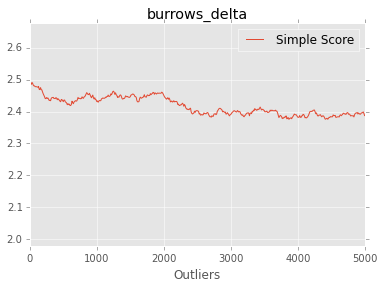

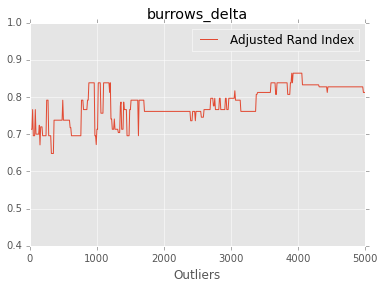

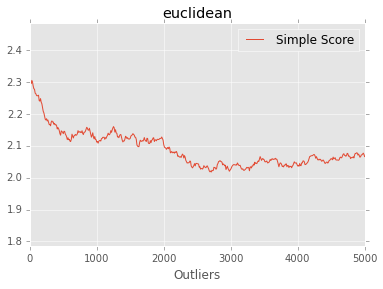

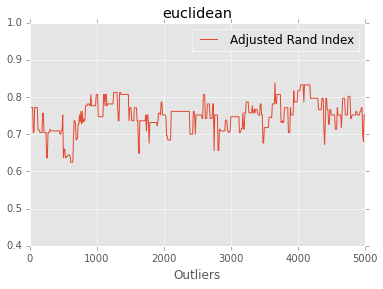

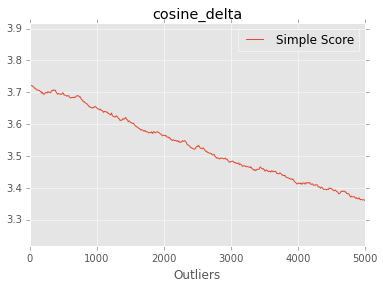

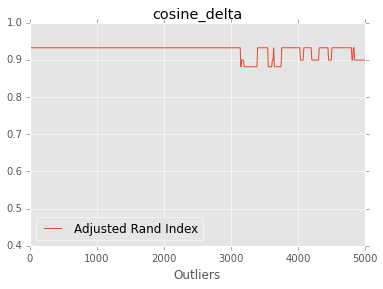

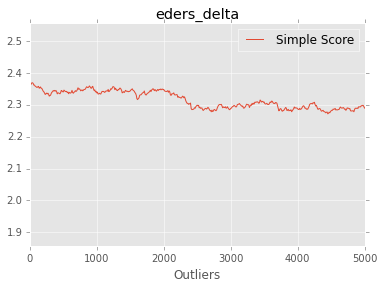

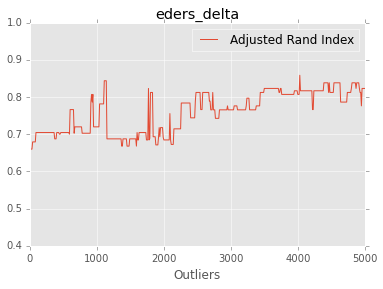

In [11]:
[(results.loc[method].plot.line(y='Simple Score', title=method, 
                                ylim=(results.at[(method,0),'Simple Score']-0.5, 
                                      results.at[(method,0),'Simple Score']+0.2)),
  results.loc[method].plot.line(y='Adjusted Rand Index', title=method, ylim=(0.4,1))) 
  for method in methods
]